In [1]:
import json
import os
import sys
from pathlib import Path
from os.path import join

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.io import loadmat, savemat
from scipy.stats import ttest_1samp, ttest_rel
from statsmodels.formula.api import ols

path_root = os.environ.get('DECIDENET_PATH')
path_code = join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data
from dn_utils.networks import zscore_network

%matplotlib inline
mpl.rcParams['font.size'] = 13

In [2]:
path_derivatives = join(path_root, 'data/main_fmri_study/derivatives')
path_out = join(path_derivatives, 'ppi')
path_nistats = join(path_derivatives, 'nistats')
path_jags = join(path_derivatives, 'jags')
path_betamats = join(path_out, 'betamats')
path_parcellations = join(path_out, 'parcellations')
path_exclusion_csv = join(path_nistats, 'exclusion/exclusion.csv')

# Behavioral data
path_beh = join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh, verbose=False)
n_subjects, n_conditions, n_trials, _ = beh.shape

# Bayesian modeling results
pmp = loadmat(join(path_jags, 'vba/pmp_HLM_sequential_split.mat'))['pmp']

# Load exclusion table
df_exclusion = pd.read_csv(path_exclusion_csv, index_col=0)
ok_index = df_exclusion.index[df_exclusion['ok_all']]

---
## Setup analysis

In [3]:
# Load betamats and ROI information
atlas_name = 'metaROI'
df_roi = pd.read_csv(join(path_parcellations, 'meta_roi/meta_roi_table.csv'), sep=',')
network_names = ['perr_inc', 'perr_dec']

# Analysis options
options = {
    'symmetrize': True,
    'only_recruitment': True,
    'zscore': True,
    'regressor_name': 'ppi_out_perr',
}

# Data to load
t_event_psycho = 1
t_event_ppi = 1
n_regs = 12
flags = ''

df_roi.head()

,abbrev,name,hemisphere,x,y,z,cluster_size,ale_score,netName,approxRadius,radius(mm)
0,dMCC,Dorsomedial cingulate cortex,R,2,24,36,12712,0.051,perr_dec,14.477995,4
1,aINS,Anterior insula,R,32,24,-2,6120,0.062,perr_dec,11.347171,4
2,aINS,Anterior insula,L,-32,22,-4,4880,0.056,perr_dec,10.522293,4
3,PAL,Pallidum,R,12,8,4,3360,0.040,perr_dec,9.291451,3
4,PAL,Pallidum,L,-14,6,2,2520,0.029,perr_dec,8.441844,3


In [4]:
dirname_load = '_'.join([
    f'tpsycho-{int(t_event_psycho * 1000)}',
    f'tppi-{int(t_event_ppi * 1000)}',
    f'nRegs-{n_regs}',
])
dirname_load = dirname_load + '_' + flags if flags else dirname_load

# PPI model regressors information
path_data = join(path_betamats, atlas_name, dirname_load, 'options_betamats.json') 
with open(path_data, 'r') as f:
    options_betamats = json.loads(f.read())

beta_names = options_betamats['regressors_save']
beta_idx = beta_names.index(options['regressor_name'])
n_regressors = len(beta_names)
n_rois, n_nets = len(df_roi), len(network_names)

print(f'Parcellation used:\n\t• {atlas_name} ({n_rois} ROIs / {n_nets} networks)')
print(f'Betamats are available for {n_regressors} regressors:\n\t• {beta_names}')
print(f'Analyzing regressor:\n\t• {beta_names[beta_idx]}')

Parcellation used:
	• metaROI (30 ROIs / 2 networks)
Betamats are available for 3 regressors:
	• ['physio', 'out_perr', 'ppi_out_perr']
Analyzing regressor:
	• ppi_out_perr


In [31]:
df_roi

,abbrev,name,hemisphere,x,y,z,cluster_size,ale_score,netName,approxRadius,radius(mm)
0,dMCC,Dorsomedial cingulate cortex,R,2,24,36,12712,0.051,perr_dec,14.477995,4
1,aINS,Anterior insula,R,32,24,-2,6120,0.062,perr_dec,11.347171,4
2,aINS,Anterior insula,L,-32,22,-4,4880,0.056,perr_dec,10.522293,4
3,PAL,Pallidum,R,12,8,4,3360,0.040,perr_dec,9.291451,3
4,PAL,Pallidum,L,-14,6,2,2520,0.029,perr_dec,8.441844,3
5,mFG1,Middle frontal gyrus 1,R,38,4,32,3152,0.029,perr_dec,9.095625,4
6,mFG2,Middle frontal gyrus 2,R,30,10,56,488,0.021,perr_dec,4.884016,4
7,mFG,Middle frontal gyrus,L,-28,12,60,104,0.019,perr_dec,2.917303,4
8,IPL,Inferior parietal lobule,R,40,-48,42,2416,0.039,perr_dec,8.324077,4
9,IPL,Inferior parietal lobule,L,-38,-48,42,2216,0.043,perr_dec,8.087738,4


---

### Load beta matrices

Here, PPI matrices (each "connection" value is actually beta value for PPI GLM model, hence the name `beta_mats`) are loaded and aggregated over subjects and task conditions. Symmetrical version of matrices are created. These symmetrical version are then used to create average within and between subnetwork strenght matrices. 

- `beta_mats_agg`: beta_matrices (shape `n_regressors` $\times$ `n_rois` $\times$ `n_rois)` aggregated over subjects and tasks)
- `beta_mats_agg_trans`: version with beta weights symmetrized for connections `ij` and `ji` 
- `nets_mats_agg_trans`: connection strengths are averaged across subnetworks (↑pe network and ↓pe network)

In [5]:
beta_mats_agg = np.zeros(
    (n_subjects, n_conditions, n_regressors, n_rois, n_rois))
beta_mats_agg_trans = np.zeros(
    (n_subjects, n_conditions, n_regressors, n_rois, n_rois))
nets_mats_agg_trans = np.zeros(
    (n_subjects, n_conditions, n_regressors, n_nets, n_nets))

# Aggregate and transform beta matrices
for con, con_name in enumerate(meta['dim2']):
    for sub, sub_name in enumerate(meta['dim1']):
        
        beta_mats_fname = f'sub-{sub_name}_task-{con_name}_betamats.npy'
        beta_mats = np.load(join(path_betamats, atlas_name, dirname_load, 
                                 beta_mats_fname))
        beta_mats_agg[sub, con] = beta_mats
        
        # Apply transformations
        beta_mats_trans = np.copy(beta_mats)
        
        for b in range(len(beta_mats_trans)):
            np.fill_diagonal(beta_mats_trans[b], val=np.nan)
        
        if options['symmetrize']:
            beta_mats_trans = beta_mats_trans \
                            + np.transpose(beta_mats_trans, (0, 2, 1))
            beta_mats_trans = beta_mats_trans / 2
        
        if options['zscore']:
            for b, beta_mat_trans in enumerate(beta_mats_trans):
                beta_mats_trans[b] = zscore_network(beta_mat_trans)

        
        beta_mats_agg_trans[sub, con] = beta_mats_trans 
        
# Calculate network-level mean values (for transformed beta_mats)
for i, net_i in enumerate(network_names):
    for j, net_j in enumerate(network_names):
        net_i_idx = df_roi[df_roi['netName'] == net_i].index
        net_j_idx = df_roi[df_roi['netName'] == net_j].index
        nets_mats_agg_trans[:, :, :, i, j] = np.nanmean(
            beta_mats_agg_trans[:, :, :, net_i_idx, :][:, :, :, :, net_j_idx], 
            axis=(-1, -2))
        
# Filter excluded subjects
beta_mats_agg = beta_mats_agg[ok_index]
beta_mats_agg_trans = beta_mats_agg_trans[ok_index]
nets_mats_agg_trans = nets_mats_agg_trans[ok_index]
        
# Save to MATLAB file for further NBS use
path_nbs = join(path_betamats, atlas_name, dirname_load, 'nbs')
Path(path_nbs).mkdir(exist_ok=True)
nbs_beta_mats = np.concatenate((beta_mats_agg_trans[:, 0, beta_idx, :, :], 
                                beta_mats_agg_trans[:, 1, beta_idx, :, :]),
                               axis=0)
nbs_beta_mats = np.transpose(nbs_beta_mats, axes=[1, 2, 0])
savemat(join(path_nbs, 'nbs_betamats.mat'),
        {'nbs_beta_mats': nbs_beta_mats})

print('beta_mats_agg_trans.shape:', beta_mats_agg_trans.shape)
print('nets_mats_agg_trans.shape:', nets_mats_agg_trans.shape)
print('nbs_beta_mats.shape:', nbs_beta_mats.shape)

beta_mats_agg_trans.shape: (29, 2, 3, 30, 30)
nets_mats_agg_trans.shape: (29, 2, 3, 2, 2)
nbs_beta_mats.shape: (30, 30, 58)


## Question 1
---
Test whether within and between subnetworks strenght depends on subnetwork type and task condition.  

,sum_sq,df,F,PR(>F)
C(condition),0.009304,1.0,0.181408,0.670983
C(net),0.164424,1.0,3.205924,0.076074
C(condition):C(net),0.032287,1.0,0.629533,0.429204
Residual,5.744205,112.0,NaN,NaN


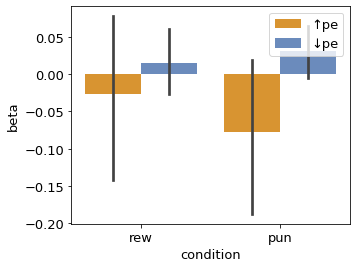

In [6]:
data = []
nets_dict = {'↑pe': (0, 0), '↓pe': (1, 1)}
if not options['only_recruitment']:
    nets_dict.update({'↑↓i': (1, 0)})
    if not options['symmetrize']:
        nets_dict.update({'↓↑i': (0, 1)})
    
for sub, sub_name in enumerate(df_exclusion.loc[ok_index, 'sub']):
    for con, con_name in enumerate(meta['dim2']):
        for net, netidx in nets_dict.items():
            data.append(
                [
                    nets_mats_agg_trans[sub, con, beta_idx, netidx[0], netidx[1]],
                    sub_name,
                    con_name,
                    net
                ]
            )
            
df = pd.DataFrame(data, columns=['beta', 'sub_name', 'condition', 'net'])

# Two-way ANOVA
model = ols('beta ~ C(condition) + C(net) + C(condition):C(net)', data=df).fit()
df_anova = sm.stats.anova_lm(model, typ=2)

# Figure 
fig, ax = plt.subplots(figsize=(5, 4))
bp = sns.barplot(
    x='condition', 
    y='beta', 
    hue='net',
    data=df,
    ax=ax,
    palette={'↑pe': '#f49915', '↓pe': '#5E88CA', '↑↓i': 'gray', '↓↑i': 'gray'}
)
plt.legend(loc='upper right')

df_anova

In [13]:
from statsmodels.stats.anova import AnovaRM
res = AnovaRM(data=df, depvar='beta', subject='sub_name', within=['net', 'condition']).fit()
print(res)

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
net            1.7739 1.0000 28.0000 0.1936
condition      0.4111 1.0000 28.0000 0.5266
net:condition  0.7835 1.0000 28.0000 0.3836



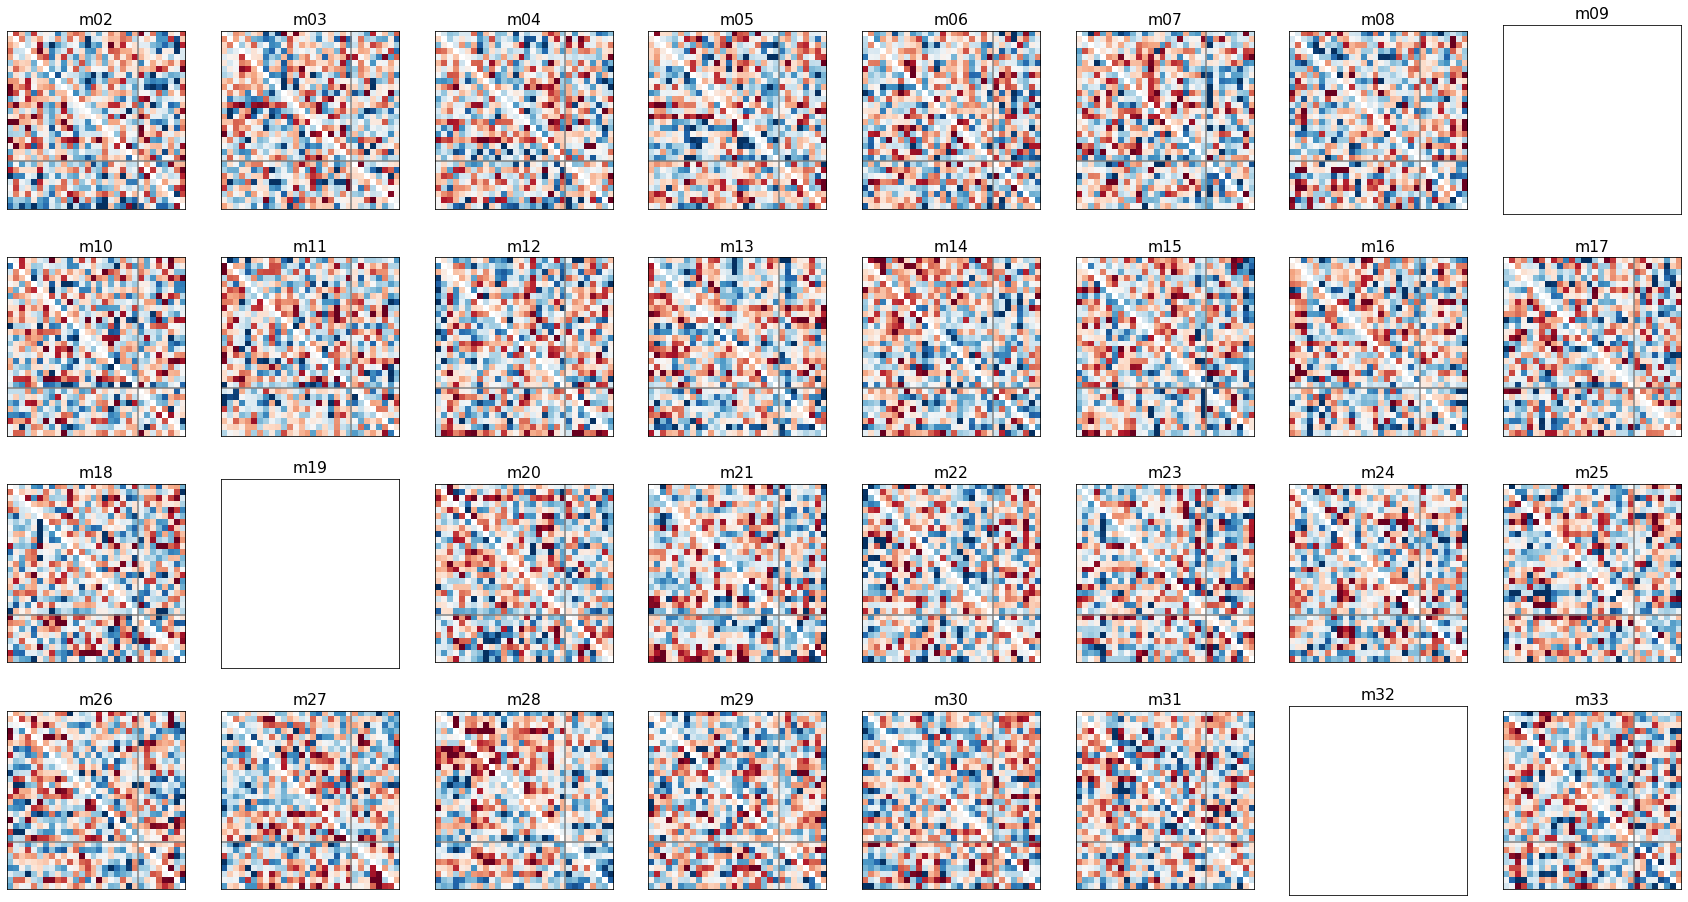

In [16]:
n_rows, n_cols = 4, 8
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(30, 16))

k = 0
for i, sub in enumerate(meta['dim1']):

    axis = ax[i // n_cols][i % n_cols]
    axis.tick_params(
        axis='both',
        length=0
    )
    axis.set_xticklabels([])
    axis.set_yticklabels([])
    axis.set_title(sub)
    
    if df_exclusion.loc[df_exclusion['sub'] == sub, 'ok_all'].all():
        
        mat_rew = beta_mats_agg_trans[k, meta['dim2'].index('rew'), beta_idx]
        mat_pun = beta_mats_agg_trans[k, meta['dim2'].index('pun'), beta_idx]
        mat = np.triu(mat_rew) + np.tril(mat_pun)

        k += 1
        
        axis.imshow(
            mat, 
            clim=[-2, 2],
            cmap='RdBu_r'
        )
        axis.axvline(x=21.5, color='gray')
        axis.axhline(y=21.5, color='gray')

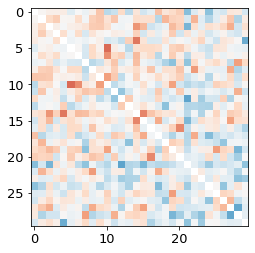

In [30]:
plt.imshow(np.mean(beta_mats_agg_trans[:, 1, beta_idx], axis=0), clim=[-1, 1], cmap='RdBu_r')


/home/kmb/miniconda3/envs/decidenet/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


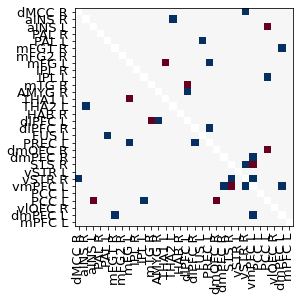

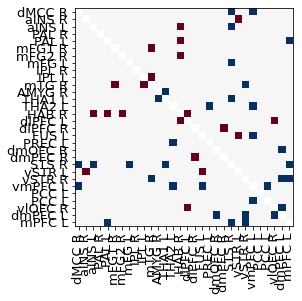

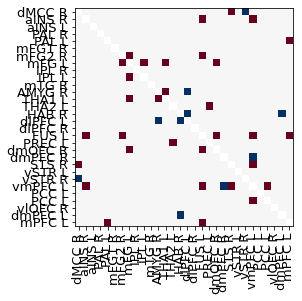

In [10]:
regions = df_roi['abbrev'] + ' ' + df_roi['hemisphere']

beta_mats_rew = beta_mats_agg_trans[:, meta['dim2'].index('rew'), beta_idx, :, :]
beta_mats_pun = beta_mats_agg_trans[:, meta['dim2'].index('pun'), beta_idx, :, :]

pval_rew = ttest_1samp(beta_mats_rew, 0, axis=0).pvalue
pval_pun = ttest_1samp(beta_mats_pun, 0, axis=0).pvalue
pval_dif = ttest_rel(beta_mats_rew, beta_mats_pun, axis=0).pvalue

pval_rew = np.nan_to_num(pval_rew, nan=1)
pval_pun = np.nan_to_num(pval_pun, nan=1)
pval_dif = np.nan_to_num(pval_dif, nan=1)

fig, ax = plt.subplots()
ax.imshow(np.mean(beta_mats_rew, axis=0) * (pval_rew < 0.05), clim=[-0.05, 0.05], cmap='RdBu_r')
ax.set_xticks(range(len(regions)))
ax.set_xticklabels(regions, rotation=90)
ax.set_yticks(range(len(regions)))
ax.set_yticklabels(regions)

fig, ax = plt.subplots()
ax.imshow(np.mean(beta_mats_pun, axis=0) * (pval_pun < 0.05), clim=[-0.05, 0.05], cmap='RdBu_r')
ax.set_xticks(range(len(regions)))
ax.set_xticklabels(regions, rotation=90)
ax.set_yticks(range(len(regions)))
ax.set_yticklabels(regions);

fig, ax = plt.subplots()
ax.imshow(np.mean(beta_mats_rew-beta_mats_pun, axis=0) * (pval_dif < 0.05), clim=[-0.05, 0.05], cmap='RdBu_r')
ax.set_xticks(range(len(regions)))
ax.set_xticklabels(regions, rotation=90)
ax.set_yticks(range(len(regions)))
ax.set_yticklabels(regions);